<a href="https://colab.research.google.com/github/duncansamuelgeorgefreeman/bert-sentiment/blob/main/autoencoder_image_denoising_minist_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  artificial neural network used to learn efficient data codings in an unsupervised manner. 
# The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”.

###Steps involved:

- Prepare input data by adding noise to MNIST dataset
- Build a CNN Autoencoder Network
- Train the network
- Test the performance of Autoencoder


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist, cifar10
%matplotlib inline

Reshape the train and test images to the required model input format [samples, 28, 28, 1], where 1 represents the number of channels. And scale the images to [0,1] by dividing with 255.

In [3]:
(train, _), (test, _)  = mnist.load_data()

In [4]:
# scaling input data
train = train.reshape([-1,28,28,1]) / 255
test = test.reshape([-1,28,28,1]) / 255

Add noise to generate the noisy images. To add noise we can generate array with same dimension of our images with random values between [0,1] using normal distribution with mean = 0 and standard deviation = 1. 

To generate normal distribution, we can use np.random.normal(loc,scale,size). Then scale the noise by some factor, here I am using 0.3. After adding noise, pixel values can be out of range [0,1], so we need to clip the values using np.clip(arr, arr_min, arr_max ).

In [5]:
train.shape

(60000, 28, 28, 1)

In [6]:
# Adding noise to data
noise = 0.3
train_noise = train + noise * np.random.normal(0, 1, size=train.shape)
test_noise = test + noise * np.random.normal(0, 1, size=test.shape)

train_noise = np.clip(train_noise, 0, 1)
test_noise = np.clip(test_noise, 0, 1)

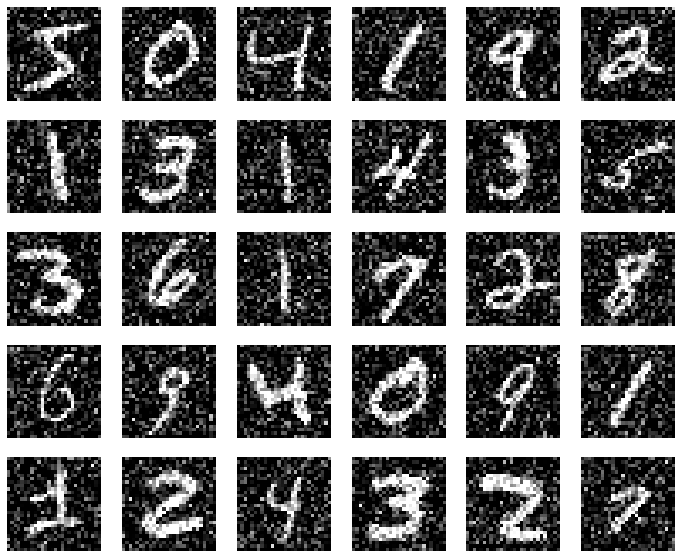

In [7]:
rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure
subplot_size = 2

f = plt.figure(figsize=(subplot_size * cols, subplot_size * rows)) # defining a figure 
for i in range(rows * cols):
  f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
  plt.imshow(train_noise[i].reshape([28,28]),cmap="gray") 
  plt.axis("off")
#plt.savefig("digits_noise.png")
plt.show()

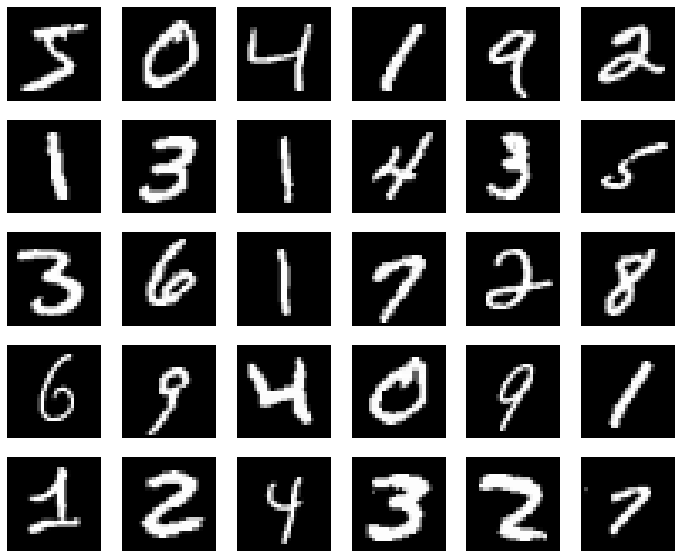

In [8]:
# sample original image

rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure
subplot_size = 2
f = plt.figure(figsize=(subplot_size*cols, subplot_size*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(train[i].reshape([28,28]),cmap="gray") 
    plt.axis("off")
#plt.savefig("digits_original.png")
plt.show()

Autoencoder Model
I am using basic CNN architecture to build the model (CNN works well with images). CNN can improve the reconstruction quality. 

Autoencoder consists of two parts:

Encoder: In Encoder, I am using 2 Conv2D layers and 2 MaxPool2D layers. The output of the 2nd MaxPool2D layer is the encoded features or the input to the Decoder.
Decoder: Decoder takes the encoder output as input. Here I used Conv2D and UpSampling2D layers. UpSampling2D layer increases the dimension, opposite of MaxPool which reduces the dimension. Output of decoder has same dimension as the input of the encoder.

**How UpSampling2D works:** The input image of shape 2x2 will be 4x4, like the example below.



```
Input = [
         [1, 2],
         [3, 4]
        ]

Output =  [
           [1, 1, 2, 2],
           [1, 1, 2, 2],
           [3, 3, 4, 4],
           [3, 3, 4, 4]
          ]

```

##Encoder

In [9]:
# Encoder 
inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

##Decoder
Activation of our output layer is sigmoid to make every value between [0,1].

In [10]:
# Decoder

x = Conv2D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

##Create and Compile Model

In [11]:
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248  

##Training

I am training for 50 epochs with batch size 256. Batch size may vary for your system. If you are using Kaggle or Colab, then 256 will work. Also, remember if you are using other dataset, it may be required to change the number of epochs and batch size.

In [ ]:
epochs = 50
batch_size = 256

history = autoencoder.fit(train_noise,
                train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_noise, test)
               )


Epoch 1/50
235/235 [==============================] - 158s 610ms/step - loss: 0.2759 - val_loss: 0.1072
Epoch 2/50
235/235 [==============================] - 144s 613ms/step - loss: 0.1170 - val_loss: 0.0962
Epoch 3/50
235/235 [==============================] - 143s 610ms/step - loss: 0.1045 - val_loss: 0.0917
Epoch 4/50
235/235 [==============================] - 145s 616ms/step - loss: 0.0988 - val_loss: 0.0894
Epoch 5/50
235/235 [==============================] - 143s 611ms/step - loss: 0.0958 - val_loss: 0.0851
Epoch 6/50
235/235 [==============================] - 143s 608ms/step - loss: 0.0937 - val_loss: 0.0844
Epoch 7/50
235/235 [==============================] - 142s 604ms/step - loss: 0.0921 - val_loss: 0.0837
Epoch 8/50
235/235 [==============================] - 143s 609ms/step - loss: 0.0912 - val_loss: 0.0833
Epoch 9/50
235/235 [==============================] - 144s 614ms/step - loss: 0.0900 - val_loss: 0.0849
Epoch 10/50
235/235 [==============================] - 143s 609m

In [ ]:
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#plt.savefig("Loss_curve.png")
plt.show()

In [ ]:
# Select few random test images
num_imgs = 16
rand = np.random.randint(1, 100)

test_images = test_noise[rand:rand+num_imgs] # slicing
test_desoided = autoencoder.predict(test_images) # predict

In [ ]:
# Visualize test images with their denoised images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_images[i*cols + j].reshape([28,28]),cmap="Reds") 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_desoided[i*cols + j].reshape([28,28]),cmap="Reds") 
        plt.axis("off")
        
f.suptitle("Autoencoder Results",fontsize=18)
#plt.savefig("test_results.png")

plt.show()

##Denoising Cifar10 Data

In [ ]:
# Load, prep data
(cifar_train, _), (cifar_test, _) = cifar10.load_data()

size = 32
channel = 3
# scaling input data
cifar_train = cifar_train / 255
cifar_test = cifar_test / 255

# Adding noise mean = 0, std = 0.3
noise = 0.3
cifar_train_noise = cifar_train + noise * np.random.normal(0, 0.3, size=cifar_train.shape) 
cifar_test_noise = cifar_test + noise * np.random.normal(0, 0.3, size=cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise = np.clip(cifar_test_noise, 0, 1)

In [ ]:
# Sample a few training images with their noisy images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
#plt.savefig("Cifar-trian.png")

plt.show()

##Model
This architecture is different from different the last model's architecture in the following ways:

Conv2DTranspose layer
No UpSampling2D layer
Skip connection from the encoder to the decoder
3 Conv2D layers followed by BatchNormalization and MaxPool2D



##Deconvolution (Conv2DTranspose)
Conv2DTranspose layer performs the inverse of that of Conv2D. It performs deconvolution, and it is much better than UpSampling. UpSampling layer copies the values to the upscaled dimension. But deconvolution layer can combine the upsampling and convolution in one layer. It fills the value by interpreting the input. But there one disadvantage also, deconvolution can lead to the Checkerboard Artifacts. You can see the artifact in below image. Read More about Checkerboard Artifacts

Checkerboard Artifacts 


Checkerboard Artifacts

Deconvolution operation deconv